In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(font_scale=1.3)
import warnings 

from itertools import product

%matplotlib inline

### Загрузка временного ряда

In [2]:
pjme_df = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])
pjme_df.sort_index(inplace=True)
pjme_df.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


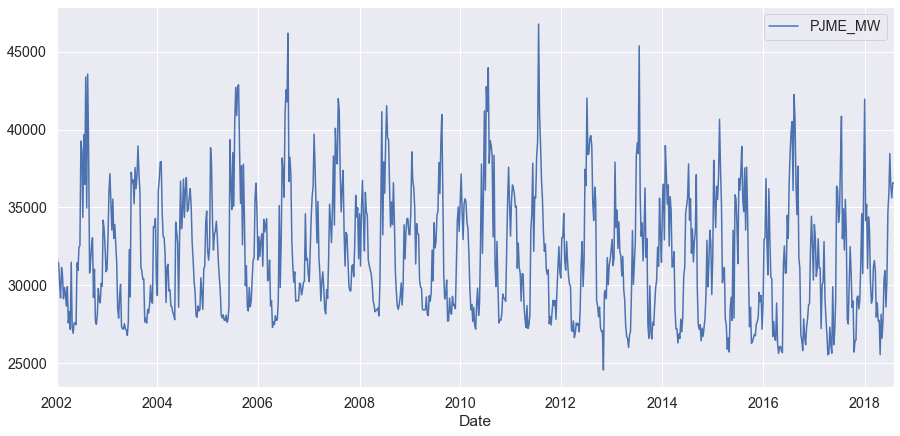

In [3]:
plt.figure(figsize=(15, 7))
pjme_weekly = pjme_df['PJME_MW'].resample('W').mean()
pjme_weekly.plot(label='PJME_MW')
plt.legend(loc='best')
plt.show()

**Отделение обучаюшей части ряда:**

In [4]:
def split_data_b(df, split_date):
    return df.loc[df.index.get_level_values(df.index.name) <= split_date].copy(), \
           df.loc[df.index.get_level_values(df.index.name) >  split_date].copy()

In [5]:
split_date = '2016-06-01'
pjme_weekly_train, pjme_weekly_test = split_data_b(pjme_weekly, split_date)

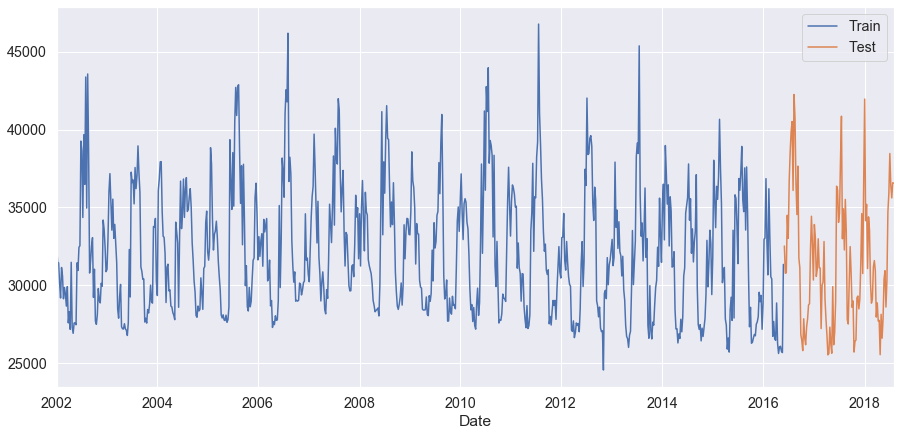

In [6]:
plt.figure(figsize=(15, 7))
pjme_weekly_train.plot(label='Train')
pjme_weekly_test.plot(label='Test')
plt.legend(loc='best')
plt.show()

### Загрузка статистических модулей и библиотек

In [7]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

### Определение максимальных границ для $p, P, d, D, q, Q$

In [8]:
adfuller(pjme_weekly_train, regression='ctt') # ‘ctt’ : constant, and linear and quadratic trend.

(-13.012552961851803,
 2.7785704408045197e-21,
 11,
 740,
 {'1%': -4.386855964965056,
  '5%': -3.8403937761929208,
  '10%': -3.55821522806892},
 13323.010467240638)

Ряд согласно критерию Дики-Фуллера стационарен, но проверим на сезонность по выборочным ACF и PACF:

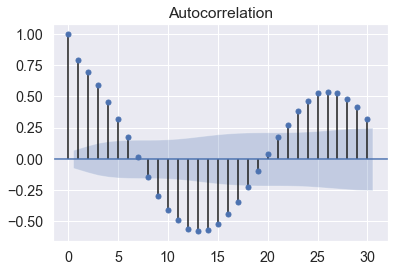

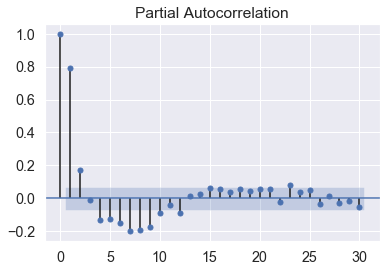

In [9]:
plot_acf(pjme_weekly_train, lags=30)
plt.show()

plot_pacf(pjme_weekly_train, lags=30)
plt.show()

Есть очевидные сезонные колебания. Поставим $S = 26$.

Произведем сезонное дифференцирование:

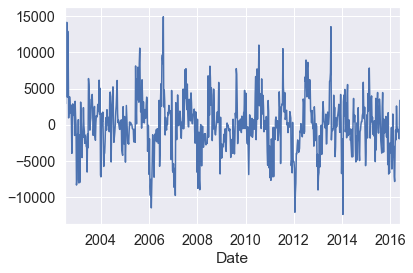

In [10]:
pjme_weekly_diff26 = pjme_weekly_train - pjme_weekly_train.shift(26)
pjme_weekly_diff26.dropna(inplace=True)
pjme_weekly_diff26.plot()
plt.show()

In [11]:
adfuller(pjme_weekly_diff26, regression='ctt') # ‘ctt’ : constant, and linear and quadratic trend.

(-7.517618546685861,
 4.877484736480022e-09,
 19,
 706,
 {'1%': -4.387616693084751,
  '5%': -3.840780408680506,
  '10%': -3.5584543692408093},
 13293.340943381576)

Колебания сохраняются, произведем обычное дифференцирование: 

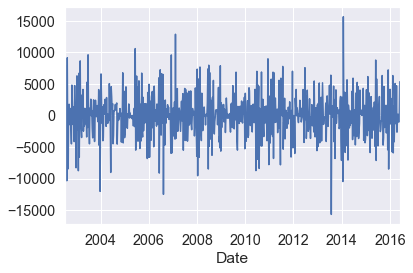

In [12]:
pjme_weekly_diff1 = pjme_weekly_diff26 - pjme_weekly_diff26.shift(1)
pjme_weekly_diff1.dropna(inplace=True)
pjme_weekly_diff1.plot()
plt.show()

In [13]:
adfuller(pjme_weekly_diff1, regression='ctt') # ‘ctt’ : constant, and linear and quadratic trend.

(-17.496165332624134,
 0.0,
 4,
 720,
 {'1%': -4.387294712488748,
  '5%': -3.840616771379887,
  '10%': -3.5583531583263674},
 13327.034983540107)

Визуально теперь ряд стационарный, критерий Дики-Фуллера это подтверждает. Определяем $d = 1, D = 1$.

Построим ACF и PACF:

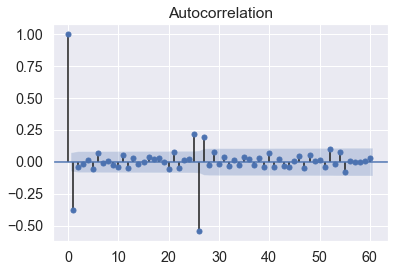

In [14]:
plot_acf(pjme_weekly_diff1,lags=60)
plt.show()

Пусть $Q = 1$ (есть значимый лаг $26$), $q = 1$.

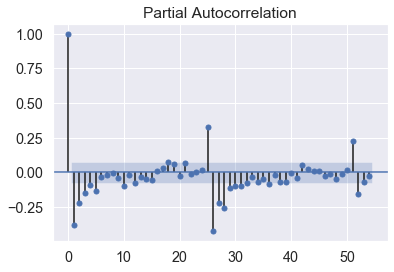

In [15]:
plot_pacf(pjme_weekly_diff1, lags=54)
plt.show()

Пусть $P = 1$ (есть значимый лаг $26$), $p = 5$.

### Поиск оптимальной модели ARIMA

**Набор параметров:**

In [16]:
S = 26
d, D = 1, 1
p, P = 1, 1
q, Q = 1, 1

ps, Ps = np.arange(0, p + 1), np.arange(0, P + 1)
qs, Qs = np.arange(0, q + 1), np.arange(0, Q + 1)

In [17]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

**Перебор параметров:**

In [18]:
%%time
results = []
opt_aic = float('inf')
warnings.filterwarnings('ignore')

for n, param in enumerate(parameters_list):
    try:
        model=SARIMAX(pjme_weekly_train, order=(param[0], d, param[1]), 
                      seasonal_order=(param[2], D, param[3], S)).fit(disp=-1)
    except:
        continue
    aic = model.aic
    if aic < opt_aic:
        opt_model = model
        opt_aic = aic
        opt_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 4min 12s


Топ-5 моделей

In [19]:
result_table = pd.DataFrame(results, columns=['parameters', 'aic'])
result_table.sort_values(by='aic', ascending=True).head()

,parameters,aic
13,"(1, 1, 0, 1)",13303.936836
15,"(1, 1, 1, 1)",13305.009128
5,"(0, 1, 0, 1)",13315.598888
7,"(0, 1, 1, 1)",13317.461151
9,"(1, 0, 0, 1)",13368.507901


**Лучшая модель:**

In [20]:
print(opt_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                            PJME_MW   No. Observations:                  752
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 26)   Log Likelihood               -6647.968
Date:                            Mon, 16 Dec 2019   AIC                          13303.937
Time:                                    06:59:46   BIC                          13322.282
Sample:                                01-06-2002   HQIC                         13311.017
                                     - 05-29-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2489      0.046      5.428      0.000       0.159       0.339
ma.L1         -0.7268      0.037   

**Анализ остатков:**

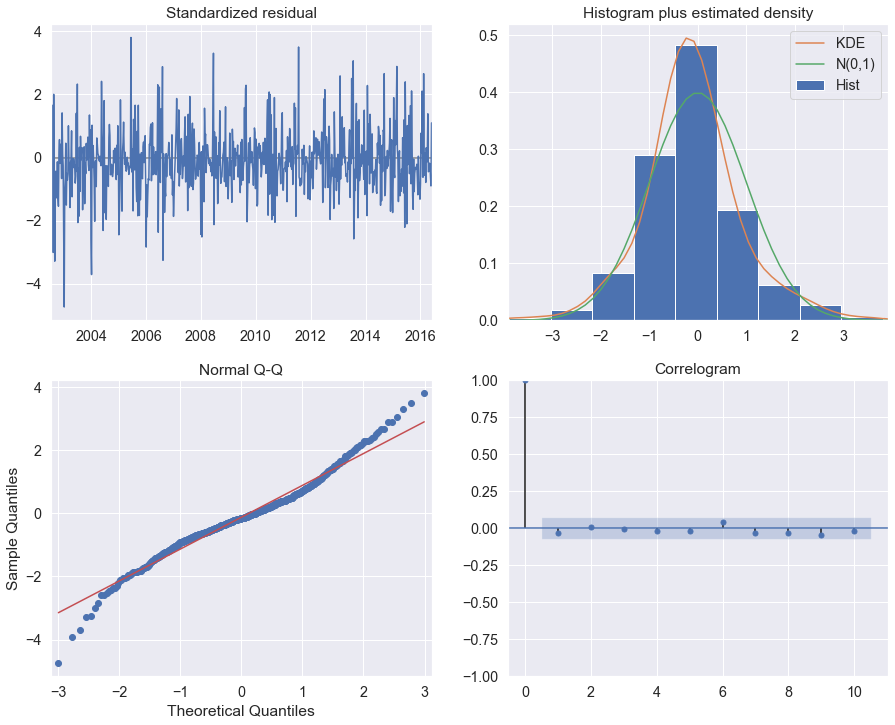

In [21]:
opt_model.plot_diagnostics(figsize=(15, 12))
plt.show()

Распределение остатков близко к нормальному.

In [22]:
adfuller(opt_model.resid)

(-28.391806243442545,
 0.0,
 0,
 751,
 {'1%': -3.4390874066174355,
  '5%': -2.8653962034740705,
  '10%': -2.568823449196012},
 13468.108093826402)

Согласно критерию Дики-Фуллера остатки стационарны.

**Графики исходного ряда и предсказанного моделью (без начального участка обучения):**

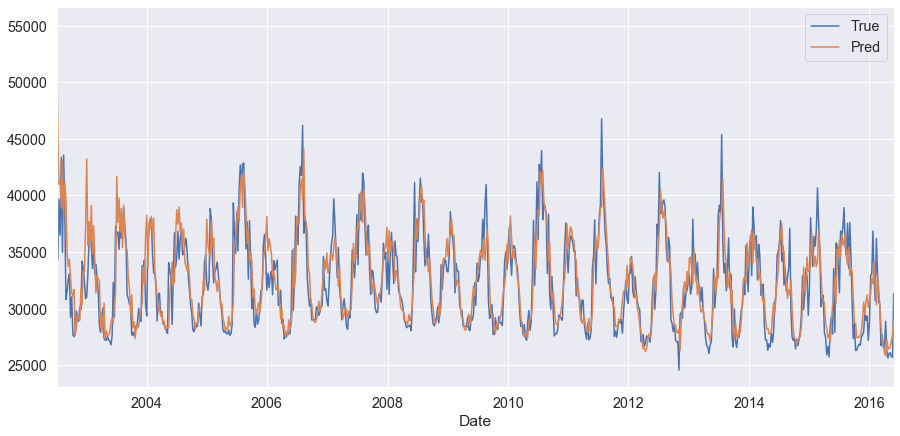

In [23]:
plt.figure(figsize=(15, 7))
pjme_weekly_train[S:].plot(label='True')
opt_model.fittedvalues[S:].plot(label='Pred')
plt.legend(loc='best')
plt.show()

### Создание признаков

Исходный ряд:

In [24]:
df = pd.DataFrame(pjme_weekly)
df.head()

,PJME_MW
Date,
2002-01-06,32392.160839
2002-01-13,31487.386905
2002-01-20,31452.880952
2002-01-27,30141.529762
2002-02-03,29196.488095


Признаки по $p, P, d, D, q, Q$ (поскольку единичны, то создаем без цикла)

In [25]:
df['p'] = pjme_weekly.shift(p)
df['P'] = pjme_weekly.shift(P*S)

df['d'] = pjme_weekly - pjme_weekly.shift(d)
df['D'] = pjme_weekly - pjme_weekly.shift(D*S)

# df['q'] = pjme_weekly.rolling(window=q).mean() - это протечка?
df['Q'] = pjme_weekly.rolling(window=Q*S).mean()

In [26]:
df.dropna(inplace=True)
df.head()

,PJME_MW,p,P,d,D,Q
Date,,,,,,
2002-07-07,38626.654762,39257.517857,32392.160839,-630.863095,6234.493923,30303.015746
2002-07-14,34359.119048,38626.654762,31487.386905,-4267.535714,2871.732143,30413.466982
2002-07-21,39671.779762,34359.119048,31452.880952,5312.660714,8218.898810,30729.578475
2002-07-28,36481.577381,39671.779762,30141.529762,-3190.202381,6340.047619,30973.426460
2002-08-04,43367.934524,36481.577381,29196.488095,6886.357143,14171.446429,31518.482092


### Разделение данных на train и test

In [27]:
train, test = split_data_b(df, split_date)

In [28]:
X_train = df.iloc[:train.shape[0], 1:]
y_train = df.iloc[:train.shape[0], 0]
X_test = df.iloc[train.shape[0]:, 1:]
y_test = df.iloc[train.shape[0]:, 0]

### Обучение модели

In [30]:
from sklearn.ensemble import GradientBoostingRegressor

In [31]:
model_g = GradientBoostingRegressor(max_depth=2, random_state=0, n_estimators=50)

In [32]:
model_g.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

### Прямое прогнозирование

In [33]:
gb_pred = pd.Series(model_g.predict(X_test),
                    index=y_test.index)

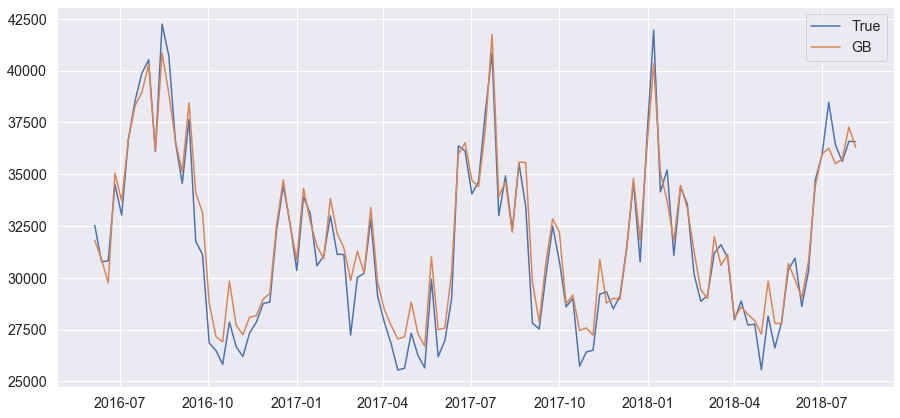

In [34]:
plt.figure(figsize=(15, 7))
plt.plot(y_test, label='True')
plt.plot(gb_pred, label='GB' )
plt.legend()
plt.show()

Модель дает достаточно близкий ответ на тестовых данных.

**Наиболее важные признаки:**

In [35]:
feature_importances = pd.Series(model_g.feature_importances_, index=X_train.columns)
feature_importances.sort_values(ascending=False)

p    0.541468
d    0.196924
D    0.182098
P    0.078661
Q    0.000849
dtype: float64

### Рекурсивное прогнозирование

Основная идея реализации - работаем в копии того же датафрейма, с границы начала тестовых данных.

In [36]:
i_test = X_train.shape[0]

In [37]:
df_rec = df.copy()

In [38]:
print(X_test.head(1).index[0])

2016-06-05 00:00:00


**Начало исходной тестовой части данных:**

In [39]:
df_rec.loc[df_rec.index.get_level_values(df_rec.index.name) >= '2016-06-05'].head(5)

,PJME_MW,p,P,d,D,Q
Date,,,,,,
2016-06-05,32529.000000,31348.488095,29562.339286,1180.511905,2966.660714,29487.011905
2016-06-12,30782.744048,32529.000000,28958.482143,-1746.255952,1824.261905,29557.175824
2016-06-19,30810.607143,30782.744048,29359.422619,27.863095,1451.184524,29612.990614
2016-06-26,34499.904762,30810.607143,27189.142857,3689.297619,7310.761905,29894.173764
2016-07-03,33018.250000,34499.904762,28855.714286,-1481.654762,4162.535714,30054.271291


**Реализация рекурсии (обновление с учетом конечной точки истории, разниц и скользуящих средних отсчетов):**

In [40]:
h = 10 # отсчетов

for i in range(h):
    df_rec.iloc[i+i_test+1, 0] = model_g.predict(df_rec.iloc[i+i_test, 1:].values.reshape(1, 5))[0]
    df_rec.iloc[i+i_test+1, 1] = df_rec.iloc[i+i_test+1-p, 0]
    df_rec.iloc[i+i_test+1, 2] = df_rec.iloc[i+i_test+1-p*S, 0]
    df_rec.iloc[i+i_test+1, 3] = df_rec.iloc[i+i_test+1, 0] - df_rec.iloc[i+i_test+1-d, 0]
    df_rec.iloc[i+i_test+1, 4] = df_rec.iloc[i+i_test+1, 0] - df_rec.iloc[i+i_test+1-D*S, 0]
    df_rec.iloc[i+i_test+1, 5] = df_rec.iloc[i+i_test+2-Q*S:i+i_test+2, 0].mean()

**Начало обновленной тестовой части данных:**

In [41]:
df_rec.loc[df_rec.index.get_level_values(df_rec.index.name) >= '2016-06-05'].head(5)

,PJME_MW,p,P,d,D,Q
Date,,,,,,
2016-06-05,32529.000000,31348.488095,29562.339286,1180.511905,2966.660714,29487.011905
2016-06-12,31802.934591,32529.000000,28958.482143,-726.065409,2844.452449,29596.413922
2016-06-19,32598.410564,31802.934591,29359.422619,795.475973,3238.987945,29720.990381
2016-06-26,33613.475327,32598.410564,27189.142857,1015.064763,6424.332470,29968.080092
2016-07-03,35520.418795,33613.475327,28855.714286,1906.943467,6664.704509,30224.414881


**10 тестовых отсчетов:**
    - прямое прогнозирование (GB);
    - рекурсивное прогнозирование (GB with recursion);
    - прогнозирование ARIMA.

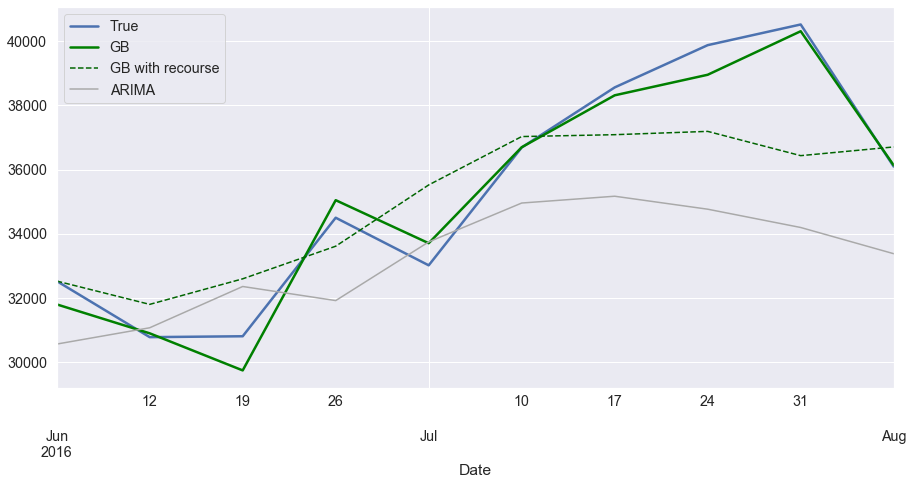

In [42]:
plt.figure(figsize=(15, 7))

test_true = df.iloc[i_test:i_test+h, 0]
test_true.plot(label='True', lw=2.5)

gb_pred[:h].plot(label='GB', c='green', lw=2.5)

test_gb_rec = df_rec.iloc[i_test:i_test+h, 0]
test_gb_rec.plot(label='GB with recourse', c='darkgreen', ls='--')

start = pjme_weekly_train.shape[0]
end = pjme_weekly_train.shape[0] + h -1
opt_model.predict(start=start, end=end).plot(label='ARIMA', c='darkgrey')

plt.legend(loc='best')
plt.show()

На сравнительно небольшом участке все прогнозы выглядят адекватно.

**Проверим рекурсивное прогнозирование на 100 тестовых отсчетах:**

In [43]:
h = 100 # отсчетов

for i in range(h):
    df_rec.iloc[i+i_test+1, 0] = model_g.predict(df_rec.iloc[i+i_test, 1:].values.reshape(1, 5))[0]
    df_rec.iloc[i+i_test+1, 1] = df_rec.iloc[i+i_test+1-p, 0]
    df_rec.iloc[i+i_test+1, 2] = df_rec.iloc[i+i_test+1-p*S, 0]
    df_rec.iloc[i+i_test+1, 3] = df_rec.iloc[i+i_test+1, 0] - df_rec.iloc[i+i_test+1-d, 0]
    df_rec.iloc[i+i_test+1, 4] = df_rec.iloc[i+i_test+1, 0] - df_rec.iloc[i+i_test+1-D*S, 0]
    df_rec.iloc[i+i_test+1, 5] = df_rec.iloc[i+i_test+2-Q*S:i+i_test+2, 0].mean()

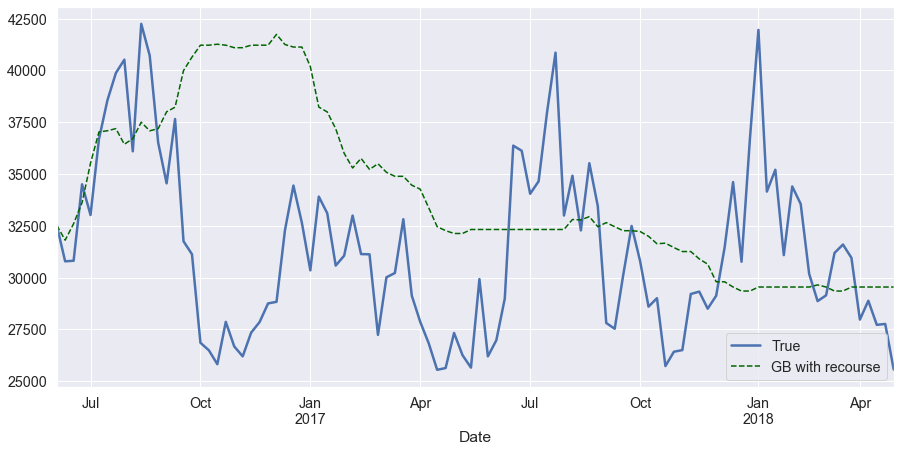

In [44]:
plt.figure(figsize=(15, 7))

test_true = df.iloc[i_test:i_test+h, 0]
test_true.plot(label='True', lw=2.5)

test_gb_rec = df_rec.iloc[i_test:i_test+h, 0]
test_gb_rec.plot(label='GB with recourse', c='darkgreen', ls='--')

plt.legend(loc='best')
plt.show()

По графикам видно, что есть участок с большим отклонением прогноза от реальных данных, и что в дальнейшем прогноз сильно сглаживается.

**Подтвердим это с помощью MAPE:** 

In [45]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Разделим 100 тестовых отсчетов на 10 участков и посчитаем для каждого MAPE:

In [46]:
mape_scores = []
for i in range(10, 110, 10):
    mape_score = mean_absolute_percentage_error(test_true[i-10:i],
                                                test_gb_rec[i-10:i])
    mape_scores.append(mape_score)

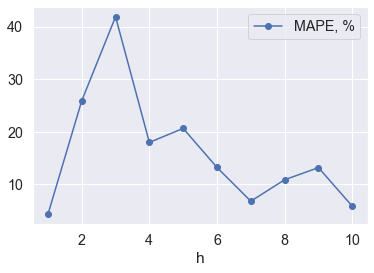

In [47]:
plt.plot(range(1, 11), mape_scores, label='MAPE, %', marker='o')
plt.legend(loc='best')
plt.xlabel('h')
plt.show()

**Вывод:** при увеличении длины прогноза (h) возникает риск, что качество рекурсивного прогноза серьезно ухудшится.